In [860]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

scaler =MinMaxScaler()

from sklearn.metrics import r2_score

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor






In [861]:
bikeSharingDf=pd.read_csv('day.csv')

print(bikeSharingDf.info())
bikeSharingDf.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Observation
- There are 730 rows with no null values so data is in good condition
- used df.info() method to evaluate null values in dataframe
- There are many categorical columns so we need to create a dummy variables for some
    * yr,mnth,weekday,season,weathersit,workingday,holiday
    * Out of these yr,workingday,holiday are already in binary so no need to create dummy varibles for them
    * Only mnth,weekday,season,weathersit need to be converted

### Plotting pair plot to identify relationship of columns

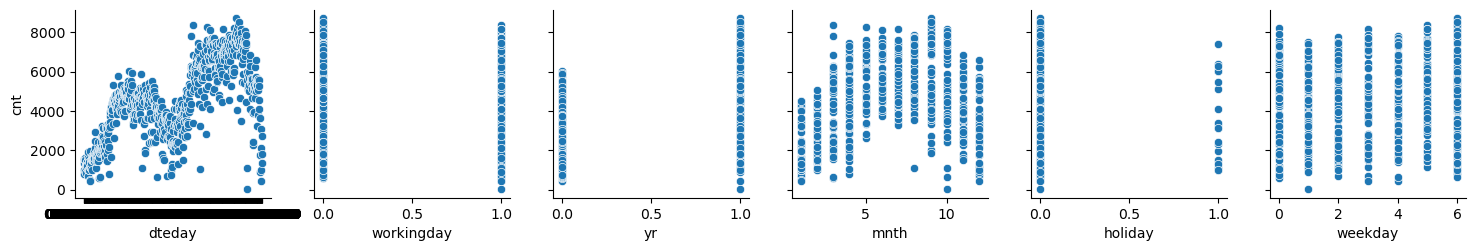

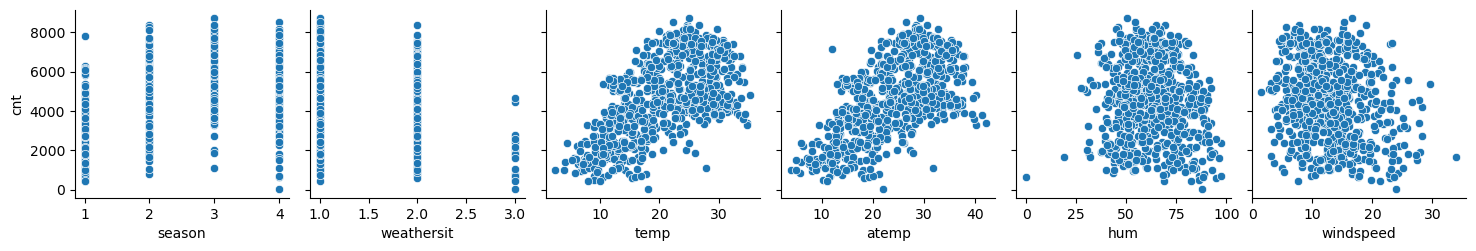

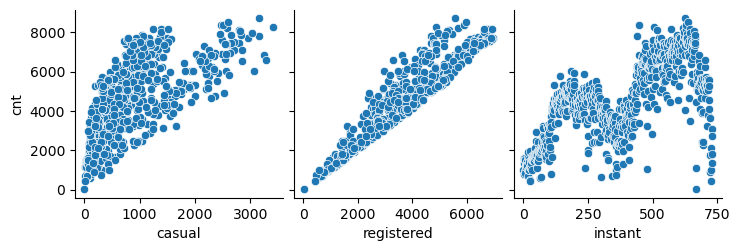

In [862]:
sns.pairplot(data=bikeSharingDf, y_vars='cnt',x_vars=['dteday', 'workingday', 'yr', 'mnth','holiday','weekday'])
sns.pairplot(data=bikeSharingDf, y_vars='cnt',x_vars=['season','weathersit','temp', 'atemp','hum','windspeed'])
sns.pairplot(data=bikeSharingDf, y_vars='cnt',x_vars=['casual', 'registered','instant'])
plt.show()


### Observation
- We should not consider columns dteday, casual and registered. dteday and instant are of no significance
- <b>cnt is direct sum of casual and registered. This will result in high multicolinear issues as CNT is completly explained by casual and registered</b>.
- 'workingday', 'yr', 'mnth','holiday','weekday','season','weathersit','temp', 'atemp','hum','windspeed' can be good candidates for linear regression model, but need dummy variables for <b>mnth,weekday,season,weathersit</b>

In [863]:
bikeSrRelavantDf=bikeSharingDf[['season', 'yr', 'mnth', 'holiday', 'weekday','workingday', 
              'weathersit', 'temp', 'atemp', 'hum', 'windspeed','cnt']]

def monthText(monthNum):
    return calendar.month_name[monthNum]

def dayText(dayNum):
    return calendar.day_name[dayNum]

def seasonText(seasonNum):
    if seasonNum==1:
        return 'spring'
    if seasonNum==2:
        return 'summer'
    if seasonNum==3:
        return 'fall'
    if seasonNum==4:
        return 'winter'
    
def weatherText(weather):
    if weather==1:
        return 'clear'
    if weather==2:
        return 'mist'
    if weather==3:
        return 'light snow'
    if weather==4:
        return 'heay rain'

bikeSrRelavantDf['mnth']=bikeSrRelavantDf['mnth'].apply(monthText)
bikeSrRelavantDf['weekday']=bikeSrRelavantDf['weekday'].apply(dayText)
bikeSrRelavantDf['season']=bikeSrRelavantDf['season'].apply(seasonText)
bikeSrRelavantDf['weathersit']=bikeSrRelavantDf['weathersit'].apply(weatherText)

dummyColLst=['mnth','weekday','season','weathersit']

seasons=pd.get_dummies(bikeSrRelavantDf['season'],drop_first=True)
bikeSrRelavantDf=pd.concat([bikeSrRelavantDf,seasons],axis=1)

weathersit=pd.get_dummies(bikeSrRelavantDf['weathersit'],drop_first=True)
bikeSrRelavantDf=pd.concat([bikeSrRelavantDf,weathersit],axis=1)

weekday=pd.get_dummies(bikeSrRelavantDf['weekday'],drop_first=True)
bikeSrRelavantDf=pd.concat([bikeSrRelavantDf,weekday],axis=1)


mnth=pd.get_dummies(bikeSrRelavantDf['mnth'],drop_first=True)
bikeSrRelavantDf=pd.concat([bikeSrRelavantDf,mnth],axis=1)


bikeSrRelavantDf=bikeSrRelavantDf.drop(columns=dummyColLst)
bikeSrRelavantDf.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,December,February,January,July,June,March,May,November,October,September
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,1,0,0,0,0,0,0,0


### Heatmap Observation
- Heatmap shows minimum 14 features have medium to strong relationship

## Dividing data into Test and Train

In [864]:
train_bikeSrRelavantDf, test_bikeSrRelavantDf=train_test_split(bikeSrRelavantDf,train_size=.7,random_state=100)
print('train data ',train_bikeSrRelavantDf.shape)
print('test data ',test_bikeSrRelavantDf.shape)



train data  (510, 30)
test data  (220, 30)


## Rescaling Data

In [865]:
colLst=list(train_bikeSrRelavantDf.columns)
train_bikeSrRelavantDf[colLst]=scaler.fit_transform(train_bikeSrRelavantDf[colLst])
train_bikeSrRelavantDf.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,December,February,January,July,June,March,May,November,October,September
576,1.0,0.0,1.0,0.815169,0.766351,0.725633,0.264686,0.827658,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
426,1.0,0.0,0.0,0.442393,0.438975,0.640189,0.255342,0.465255,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
728,1.0,0.0,0.0,0.245101,0.200348,0.498067,0.663106,0.204096,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
482,1.0,0.0,0.0,0.395666,0.391735,0.504508,0.188475,0.482973,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,1.0,0.345824,0.318819,0.751824,0.380981,0.191095,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


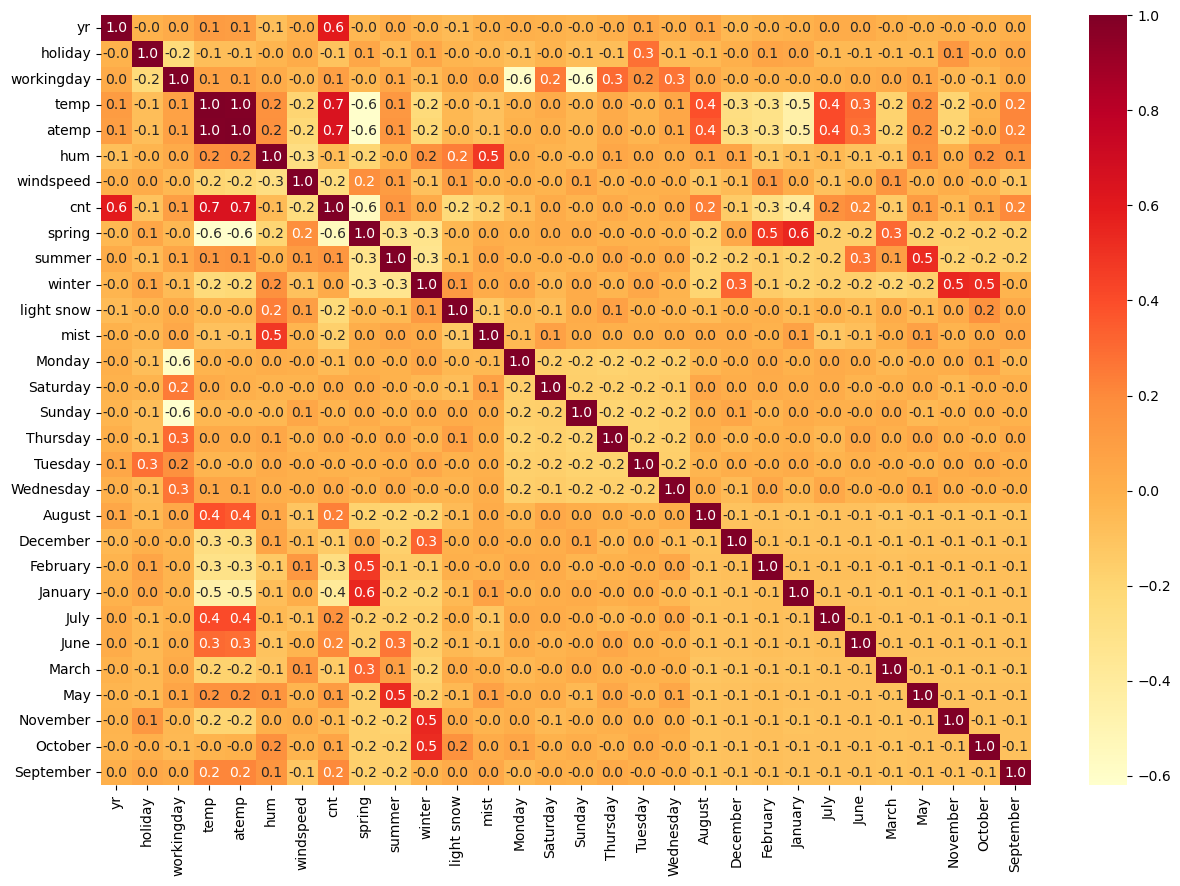

In [866]:

plt.figure(figsize=(15, 10))
sns.heatmap(round(train_bikeSrRelavantDf.corr(),2), annot=True, fmt=".1f", cmap="YlOrRd")
plt.show()

### Heatmap Observation
- Heatmap shows minimum 14 features have medium to strong relationship

## Working on Training Data, separating into x_train and y_train

In [867]:
y_train_bikeSrRelavantDf =train_bikeSrRelavantDf.pop('cnt')
x_train_bikeSrRelavantDf =train_bikeSrRelavantDf
x_train_bikeSrRelavantDf.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,...,December,February,January,July,June,March,May,November,October,September
576,1.0,0.0,1.0,0.815169,0.766351,0.725633,0.264686,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
426,1.0,0.0,0.0,0.442393,0.438975,0.640189,0.255342,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
728,1.0,0.0,0.0,0.245101,0.200348,0.498067,0.663106,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
482,1.0,0.0,0.0,0.395666,0.391735,0.504508,0.188475,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,1.0,0.345824,0.318819,0.751824,0.380981,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [868]:
linearRegression=LinearRegression()
linearRegression.fit(x_train_bikeSrRelavantDf,y_train_bikeSrRelavantDf)
rfe=RFE(linearRegression)
rfe=rfe.fit(x_train_bikeSrRelavantDf,y_train_bikeSrRelavantDf)

feature_ranking=list(zip(x_train_bikeSrRelavantDf.columns,rfe.support_,rfe.ranking_))

print('Feature Ranking : \n',feature_ranking)
rfeColLst=list(x_train_bikeSrRelavantDf.columns[rfe.support_])
print('\n')
print(rfeColLst)

# Adding January because according to heatmap it has high corelation
# rfeColLst.extend(['January'])

print('RFE selected column: \n',x_train_bikeSrRelavantDf.columns[rfe.support_])
print('\n')
print('RFE not Selected column: \n',x_train_bikeSrRelavantDf.columns[~rfe.support_])


x_train_rfe_bkSrDf=x_train_bikeSrRelavantDf[rfeColLst]
x_train_rfe_bkSrDf.head()


# x_train_rfe_bkSrDf.head()


Feature Ranking : 
 [('yr', True, 1), ('holiday', True, 1), ('workingday', True, 1), ('temp', True, 1), ('atemp', False, 6), ('hum', True, 1), ('windspeed', True, 1), ('spring', True, 1), ('summer', True, 1), ('winter', True, 1), ('light snow', True, 1), ('mist', True, 1), ('Monday', False, 9), ('Saturday', False, 12), ('Sunday', True, 1), ('Thursday', False, 15), ('Tuesday', False, 10), ('Wednesday', False, 11), ('August', False, 8), ('December', False, 4), ('February', False, 5), ('January', False, 2), ('July', True, 1), ('June', False, 14), ('March', False, 16), ('May', False, 7), ('November', False, 3), ('October', False, 13), ('September', True, 1)]


['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter', 'light snow', 'mist', 'Sunday', 'July', 'September']
RFE selected column: 
 Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'winter', 'light snow', 'mist', 'Sunday', 'July',
       'September'],
     

,yr,holiday,workingday,temp,hum,windspeed,spring,summer,winter,light snow,mist,Sunday,July,September
576,1.0,0.0,1.0,0.815169,0.725633,0.264686,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
426,1.0,0.0,0.0,0.442393,0.640189,0.255342,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
728,1.0,0.0,0.0,0.245101,0.498067,0.663106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
482,1.0,0.0,0.0,0.395666,0.504508,0.188475,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
111,0.0,0.0,1.0,0.345824,0.751824,0.380981,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


# Building model and analyzing summary

In [869]:
# Adding constant
x_train_rfe_bkSrDf_sm=sm.add_constant(x_train_rfe_bkSrDf)

# Fitting Model
linearModel=sm.OLS(y_train_bikeSrRelavantDf,x_train_rfe_bkSrDf_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
tempDf=x_train_bikeSrRelavantDf[rfeColLst]
vifDf['features']=rfeColLst
vifDf['vif']=[variance_inflation_factor(tempDf.values,i) for i in range(tempDf.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          2.11e-191
Time:                        03:18:07   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2402      0.036      6.714      0.0

,features,vif
0,yr,2.08
1,holiday,1.17
2,workingday,5.28
3,temp,16.98
4,hum,28.46
5,windspeed,4.72
6,spring,4.24
7,summer,2.85
8,winter,3.42
9,light snow,1.24


## Observations
- It can be seen that P-Values are less than .05 for all the features
- VIF for Workingday , temp and hum are greater than five

# Building model after removing feature "hum"

In [870]:
# Adding constant

x_train_rfe_bkSrDf_temp=x_train_rfe_bkSrDf.drop(['hum'],axis=1)

x_train_rfe_bkSrDf_temp_sm=sm.add_constant(x_train_rfe_bkSrDf_temp)

# Fitting Model
linearModel=sm.OLS(y_train_bikeSrRelavantDf,x_train_rfe_bkSrDf_temp_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
# tempDf=x_train_bikeSrRelavantDf[rfeColLst]

vifDf['features']=x_train_rfe_bkSrDf_temp.columns
vifDf['vif']=[variance_inflation_factor(x_train_rfe_bkSrDf_temp.values,i) for i in range(x_train_rfe_bkSrDf_temp.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.2
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          1.28e-188
Time:                        03:18:07   Log-Likelihood:                 508.20
No. Observations:                 510   AIC:                            -988.4
Df Residuals:                     496   BIC:                            -929.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1576      0.031      5.126      0.0

,features,vif
0,yr,2.07
1,holiday,1.17
2,workingday,5.20
3,temp,6.97
4,windspeed,4.65
5,spring,2.49
6,summer,2.34
7,winter,1.98
8,light snow,1.09
9,mist,1.57


## Observation

- P values are less than all the seleted features
-  Adj. R-squared drops from 0.844  to in Adj. R-squared: 0.837. This is not a large drop
- VIF is greater than 5 for workingday and temp
- We should try to removed temp and workingday


## Removing feature "temp" as "hum" is already removed in last cell

In [871]:
# Adding constant

x_train_rfe_bkSrDf_temp=x_train_rfe_bkSrDf.drop(['hum','temp'],axis=1)

x_train_rfe_bkSrDf_temp_sm=sm.add_constant(x_train_rfe_bkSrDf_temp)

# Fitting Model
linearModel=sm.OLS(y_train_bikeSrRelavantDf,x_train_rfe_bkSrDf_temp_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
# tempDf=x_train_bikeSrRelavantDf[rfeColLst]

vifDf['features']=x_train_rfe_bkSrDf_temp.columns
vifDf['vif']=[variance_inflation_factor(x_train_rfe_bkSrDf_temp.values,i) for i in range(x_train_rfe_bkSrDf_temp.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     137.9
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          1.68e-149
Time:                        03:18:07   Log-Likelihood:                 412.53
No. Observations:                 510   AIC:                            -799.1
Df Residuals:                     497   BIC:                            -744.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5417      0.021     26.338      0.0

,features,vif
0,yr,1.91
1,holiday,1.13
2,workingday,3.82
3,windspeed,4.22
4,spring,2.31
5,summer,2.29
6,winter,1.98
7,light snow,1.08
8,mist,1.56
9,Sunday,1.69


## Observations
- Removing Temp reduces Adj. R-squared from 0.763 to .837. This is a significant drop
- Removing Temp also increases P-Value for other fetaure such as July
- These to reasons make it a bad choice to remove temp
- Another Good option t remove is workingday and sunday both of them have low corelation with cnt(independent variable) i.e 0
- VIF value of workingday is greater than 5 when we removed feature only hum (5.2)

## Removing hum, workingday and Sunday

In [872]:
# Adding constant

x_train_rfe_bkSrDf_temp=x_train_rfe_bkSrDf.drop(['hum','workingday','Sunday'],axis=1)

x_train_rfe_bkSrDf_temp_sm=sm.add_constant(x_train_rfe_bkSrDf_temp)

# Fitting Model
linearModel=sm.OLS(y_train_bikeSrRelavantDf,x_train_rfe_bkSrDf_temp_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
# tempDf=x_train_bikeSrRelavantDf[rfeColLst]

vifDf['features']=x_train_rfe_bkSrDf_temp.columns
vifDf['vif']=[variance_inflation_factor(x_train_rfe_bkSrDf_temp.values,i) for i in range(x_train_rfe_bkSrDf_temp.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     229.6
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          5.06e-187
Time:                        03:18:07   Log-Likelihood:                 498.80
No. Observations:                 510   AIC:                            -973.6
Df Residuals:                     498   BIC:                            -922.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1994      0.030      6.746      0.0

,features,vif
0,yr,2.07
1,holiday,1.04
2,temp,5.09
3,windspeed,4.60
4,spring,2.08
5,summer,2.23
6,winter,1.78
7,light snow,1.08
8,mist,1.55
9,July,1.58


## Observations
- There is no significant drop in Adj. R-squared. It is still .832
- Prob (F-statistic):          5.06e-187 is almost zero
- No p-value is greater than .05
- VIF values are below 5 and temp is 5.09 . Which can be accepted as removing temp resulted in large drop in Adj R-sq value

<Axes: ylabel='Density'>

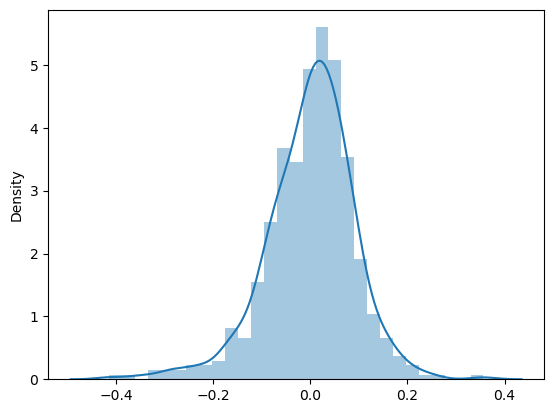

In [873]:
y_train_pred=linearModel.predict(x_train_rfe_bkSrDf_temp_sm)
residual=y_train_bikeSrRelavantDf-y_train_pred

sns.distplot(residual)

### Error Terms have normal distribution and centered around zero

## Working for Test Data

In [874]:
colTestLst=test_bikeSrRelavantDf.columns
test_bikeSrRelavantDf[colTestLst]=scaler.transform(test_bikeSrRelavantDf[colTestLst])

y_test_bikeSrRelavantDf=test_bikeSrRelavantDf.pop('cnt')

print(y_test_bikeSrRelavantDf)

x_test_bikeSrRelavantDf_sm=sm.add_constant(test_bikeSrRelavantDf)


colLstTest=list(x_train_rfe_bkSrDf_temp.columns)
colLstTest.append('const')

x_test_bikeSrRelavantDf_sm=x_test_bikeSrRelavantDf_sm[colLstTest]

y_testPred=linearModel.predict(x_test_bikeSrRelavantDf_sm)
y_testPred


r2_score(y_true=y_test_bikeSrRelavantDf, y_pred=y_testPred)

184    0.692706
535    0.712034
299    0.303382
221    0.547400
152    0.569029
         ...   
702    0.757478
127    0.495973
640    0.868615
72     0.232858
653    0.864243
Name: cnt, Length: 220, dtype: float64


-3.2818903285829935